In [0]:
import pandas as pd 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
#Download data
data = pd.read_csv('Extra_Train_1.csv')
data = data.drop(['geometry', 'Unnamed: 0'], axis = 1)
data_old = pd.read_csv('Train.csv')
data.head()
#in range(21,-1) we have 2019 predictors

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,precip 2014-12-28 - 2015-01-04,precip 2015-01-04 - 2015-01-11,precip 2015-01-11 - 2015-01-18,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15,precip 2019-01-20 - 2019-01-27,precip 2019-01-27 - 2019-02-03,precip 2019-02-03 - 2019-02-10,precip 2019-02-10 - 2019-02-17,precip 2019-02-17 - 2019-02-24,precip 2019-02-24 - 2019-03-03,precip 2019-03-03 - 2019-03-10,precip 2019-03-10 - 2019-03-17,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID,wetland_dist,soil_carbon
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.465740,4.751131
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.216010,4.977375
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,16645.902409,3.393665
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,17087.784546,3.393665
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,17589.245651,3.167420


In [0]:
#Merge info about wetland distance
data_old['wetland_dist'] = data['wetland_dist']
data_old['soil_carbon'] = data['soil_carbon']
data_old.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,precip 2014-12-28 - 2015-01-04,precip 2015-01-04 - 2015-01-11,precip 2015-01-11 - 2015-01-18,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15,precip 2019-01-20 - 2019-01-27,precip 2019-01-27 - 2019-02-03,precip 2019-02-03 - 2019-02-10,precip 2019-02-10 - 2019-02-17,precip 2019-02-17 - 2019-02-24,precip 2019-02-24 - 2019-03-03,precip 2019-03-03 - 2019-03-10,precip 2019-03-10 - 2019-03-17,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID,wetland_dist,soil_carbon
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.465740,4.751131
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.216010,4.977375
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,16645.902409,3.393665
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,17087.784546,3.393665
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,17589.245651,3.167420


In [0]:
data_old.query('target_2015>0.8').iloc[3,4:21].T.plot()

In [0]:
#Make list with X and Y which have target more than 0.96
list_max = []
for index in range(data_old.shape[0]):
  line = data_old.iloc[index]
  if (line[2]-0.96)>=0.:
    list_max.append((line[0],line[1]))
len(list_max)

522

In [0]:
#It's function for applying values which can't be possible
def asnul(x):
  """Replace less then zeros to zeros for all DF"""
  r = x
  if r[1]<0:
    r[1] = 0.0
  if r[1] > 1:
    r[1] = 1.0
  return r

In [0]:
sns.jointplot(x='X', y='Y', data = data.loc[data.LC_Type1_mode==17][['X','Y']])
sns.jointplot(x='X', y='Y', data = data[['X','Y']])

0 -- 0.1999240675
1 -- 0.3989935753
2 -- 0.5992720367000001
3 -- 0.7981706545
4 -- 0.9998101025


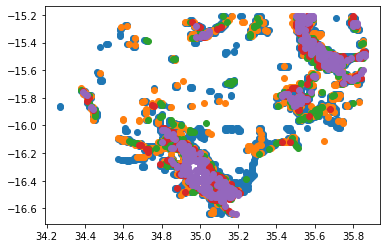

In [0]:
#It's plot of target values with coordinates
prosses = data_old[['X', 'Y', 'target_2015']]
values = []
for i in range(5):
  values.append(data_old.query('target_2015>@i*0.2&target_2015<(@i+1)*0.2'))
figure = plt.figure()
for i in range(5):
  plt.scatter(np.array(values[i].X), np.array(values[i].Y))
  print(i, '--', values[i].target_2015.max())
plt.show()

In [0]:
#Functions for applying values for more reality
def asminus(x):
  if x<0.18:
    return 0.
  if x>1:
    return 1
  return x
def delete(x):
  r = x
  if r[1]<35.65 or r[2]>-15.53:
    r[-1]=0.
  return r

0 -- 0.19689901627683604
1 -- 0.39988647325766896
2 -- 0.5979791134827892
3 -- 0.7983901558717384
4 -- 0.9711500364418648


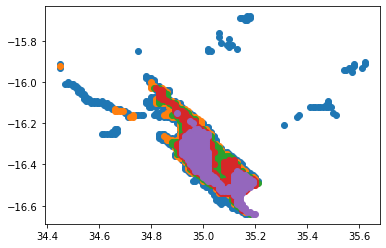

In [0]:
#Best solution which we need to merge with predictions(in the last one we predict it)
best = pd.read_csv('submit_mal (6).csv')
best = best.merge(data_old[['Square_ID', 'X', 'Y']], on='Square_ID')
y_best = best.target_2019
best = best.rename(columns = {'target_2019': 'target'})
values = []
for i in range(5):
  values.append(best.query('target>@i*0.2&target<(@i+1)*0.2'))
figure = plt.figure()
for i in range(5):
  plt.scatter(np.array(values[i].X), np.array(values[i].Y))
  print(i, '--', values[i].target.max())
plt.show()

In [0]:
!pip install catboost

     |████████████████████████████████| 64.7MB 57kB/s 


In [0]:
#Make distance between coordinates and other coordinates which we have at list higher
def distance(x):
  r = x
  if (r[2]-0.96)>=0:
    return r
  min_dist = 3.
  for i in range(len(list_max)):
    min_dist = np.min([min_dist, np.sqrt((r[0]-list_max[i][0])**2+(r[1]-list_max[i][1])**2)])
  r[-1] = min_dist
  return r

In [0]:
#Let's make this values
data_old['distance_flood'] = 0
data_old = data_old.apply(distance, axis = 1)
data_old.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,precip 2014-12-28 - 2015-01-04,precip 2015-01-04 - 2015-01-11,precip 2015-01-11 - 2015-01-18,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15,precip 2019-01-20 - 2019-01-27,precip 2019-01-27 - 2019-02-03,precip 2019-02-03 - 2019-02-10,precip 2019-02-10 - 2019-02-17,precip 2019-02-17 - 2019-02-24,precip 2019-02-24 - 2019-03-03,precip 2019-03-03 - 2019-03-10,precip 2019-03-10 - 2019-03-17,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID,wetland_dist,soil_carbon,distance_flood
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.465740,4.751131,0.190263
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.216010,4.977375,0.191050
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,16645.902409,3.393665,0.188680
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,17087.784546,3.393665,0.183576
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,17589.245651,3.167420,0.178885


In [0]:
#It's function make volume of flood(approximately)
def knull(x):
  """Count number of zeros"""
  r = x
  summ = 0
  for i in range(8,len(r)-1):
    summ+=r[i]
  r[-1] = summ/(r[6]*10)
  r[7] = summ*r[2]/(r[7]*(r[3]+1))
  return r

In [0]:
#Make train and test data
X = data_old.query('Y<=-15.9').iloc[:,[-4,-1,-2,-3,0,1,3,-5,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]]
X = pd.DataFrame(X.values, columns = range(25))
X['volume'] = 0
X = X.apply(knull, axis = 1)
X = X.iloc[:,[7,1,3,4,5,6,-1]].rename(columns = {7:'peace', 1:'distance_flood', 3:'wetland_dist', 4:'X', 5:'Y', 6:'elevation'})
y = data_old.query('Y<=-15.9').iloc[:,2]
X_test_2019 = data_old.query('Y<=-15.9').iloc[:,[-4,-1,-2,-3,0,1,3,-5,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]]
X_test_2019 = pd.DataFrame(X_test_2019.values, columns = range(25))
X_test_2019['volume'] = 0
X_test_2019 = X_test_2019.apply(knull, axis = 1)
X_test_2019 = X_test_2019.iloc[:,[7,1,3,4,5,6,-1]].rename(columns = {7:'peace', 1:'distance_flood', 3:'wetland_dist', 4:'X', 5:'Y', 6:'elevation'})

In [0]:
X.head()

,peace,distance_flood,wetland_dist,X,Y,elevation,volume
0,0.008357,0.190263,15953.465740,34.26,-15.91,887.764222,0.028449
1,0.008587,0.191050,16265.216010,34.26,-15.90,743.403912,0.033973
2,0.000000,0.180000,14655.331058,34.27,-15.92,826.058090,0.030574
3,0.009792,0.180278,14910.959896,34.27,-15.91,782.353762,0.032282
4,0.009162,0.181108,15243.998851,34.27,-15.90,775.973573,0.032547


In [0]:
#Our first model with CatBoostRegressor
from catboost import CatBoostRegressor
errcb2=[]
y_pred_totcb2=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
fold=KFold(n_splits=20)#15#5#10
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = CatBoostRegressor(n_estimators=900,eval_metric='RMSE',learning_rate=0.1, random_state=42, use_best_model=True )
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=100,)#erly100
    preds=m2.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    errcb2.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = m2.predict(X_test_2019)
    y_pred_totcb2.append(p2)
np.mean(errcb2)

0:	learn: 0.2470478	test: 0.2470478	test1: 0.1139362	best: 0.1139362 (0)	total: 50.7ms	remaining: 45.5s
100:	learn: 0.0811748	test: 0.0811748	test1: 0.0607944	best: 0.0604238 (76)	total: 346ms	remaining: 2.73s
200:	learn: 0.0704668	test: 0.0704668	test1: 0.0620874	best: 0.0604238 (76)	total: 633ms	remaining: 2.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.06042379718
bestIteration = 76

Shrink model to first 77 iterations.
err:  0.060423797134554195
0:	learn: 0.2473286	test: 0.2473286	test1: 0.1005577	best: 0.1005577 (0)	total: 3.44ms	remaining: 3.1s
100:	learn: 0.0822103	test: 0.0822103	test1: 0.0397139	best: 0.0396897 (98)	total: 333ms	remaining: 2.63s
200:	learn: 0.0712900	test: 0.0712900	test1: 0.0393183	best: 0.0393067 (199)	total: 625ms	remaining: 2.17s
300:	learn: 0.0635200	test: 0.0635200	test1: 0.0397634	best: 0.0392306 (202)	total: 928ms	remaining: 1.85s
400:	learn: 0.0580891	test: 0.0580891	test1: 0.0410182	best: 0.0392306 (202)	total: 1.22s	remaini

0.08721574942667118

In [0]:
df = pd.DataFrame(data_old.query('Y<=-15.9').iloc[:,[-4,0,1]])
y_cat = np.array(list(map(asminus, np.mean(y_pred_totcb2, 0))))
df['target_2019'] = y_cat
df.head()

,Square_ID,X,Y,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,34.26,-15.91,0.0
1,4e3c3897-14ce-11ea-bce5-f49634744a41,34.26,-15.90,0.0
9,4e3c389f-14ce-11ea-bce5-f49634744a41,34.27,-15.92,0.0
10,4e3c38a0-14ce-11ea-bce5-f49634744a41,34.27,-15.91,0.0
11,4e3c38a1-14ce-11ea-bce5-f49634744a41,34.27,-15.90,0.0


0 -- 0.1992221678340244
1 -- 0.3873193469164556
2 -- 0.5994250000177164
3 -- 0.7992716517829938
4 -- 0.9927796640580484


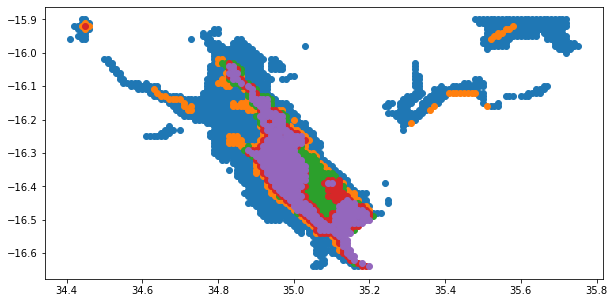

In [0]:
values = []
for i in range(5):
  values.append(df.query('target_2019>@i*0.2&target_2019<=(@i+1)*0.2'))
figure = plt.figure(figsize=(10,5))
for i in range(5):
  plt.scatter(np.array(values[i].X), np.array(values[i].Y))
  print(i, '--', values[i].target_2019.max())
plt.show()

Than we make our best solution


In [0]:
def asminus(x):
  if x<0.18:
    return 0
  if x>1:
    return 1
  return x

In [0]:
"""Лучшая модель для нижней части координат"""#Best model for low part of coordinates
model_lgb_low = lgb.LGBMRegressor(n_estimators=900, max_depth=4, learning_rate=0.2)
model_lgb_low.fit(X,y)
print('CV =', cross_val_score(model_lgb_low, X_test, y_test, scoring='neg_root_mean_squared_error', cv = 5).mean())
y_pred_lgb = model_lgb_low.predict(X)
print("LGB =", np.sqrt(mean_squared_error(y, y_pred_lgb)))

CV = -0.11847830010898068
LGB = 0.03822843806100366


In [0]:
y_pred_lgb_low = model_lgb_low.predict(X_test_2019)
y_pred_lgb[:10]

array([ 0.00690217,  0.00326833, -0.00215547,  0.00066217,  0.00577791,
        0.00342995,  0.00020694, -0.00184484,  0.0074338 ,  0.00167421])

In [0]:
#Fiting models without CV
"""IT IS BEST MODEL!!!!!!!"""
model_1_low = xgb.XGBRegressor(n_estimators = 300,max_depth = 15, learning_rate = 0.2, random_state = 42, gamma = 0.11, min_child_weight = 15, objective = 'reg:squarederror')#5
model_1_low.fit(X, y)
y_pred_xgb = model_1_low.predict(X)
y_pred_xgb = np.array(list(map(asminus, y_pred_xgb)))
print("XGB =", np.sqrt(mean_squared_error(y, y_pred_xgb)))
model_2_low = SVR(C = 50)
model_2_low.fit(X, y)
y_pred_svr = model_2_low.predict(X)
y_pred_svr = np.array(list(map(asminus, y_pred_svr)))
print("SVR =", np.sqrt(mean_squared_error(y, y_pred_svr)))
y_mean = (y_pred_xgb + y_pred_svr)/2
print("Mean =", np.sqrt(mean_squared_error(y, y_mean)))

XGB = 0.06476118564993462
SVR = 0.16162252632250906
Mean = 0.10075568667578463


In [0]:
"""IT IS BEST MODEL!!!!!!!"""
#Mean of three models
df_low = pd.DataFrame(data_old.query('Y<=-15.9').iloc[:,[-4,0,1]])
y_pred = (np.array(list(map(asminus, model_1_low.predict(X))))
          +np.array(list(map(asminus, y_pred_lgb_low)))
         +np.array(list(map(asminus, model_2_low.predict(X)))))/3.4
df_low['target_2019'] = np.array(list(map(asminus, y_pred)))
"""Конец модели"""
df_low.head()

,Square_ID,X,Y,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,34.26,-15.91,0.0
1,4e3c3897-14ce-11ea-bce5-f49634744a41,34.26,-15.90,0.0
9,4e3c389f-14ce-11ea-bce5-f49634744a41,34.27,-15.92,0.0
10,4e3c38a0-14ce-11ea-bce5-f49634744a41,34.27,-15.91,0.0
11,4e3c38a1-14ce-11ea-bce5-f49634744a41,34.27,-15.90,0.0


0 -- 0.0999616758673224
1 -- 0.1996392522231664
2 -- 0.299364072713938
3 -- 0.3998278455708936
4 -- 0.49958477511269406
5 -- 0.5930283304013363
6 -- 0.6990939980968373
7 -- 0.7996614597119122
8 -- 0.8695652173913043
9 -- nan


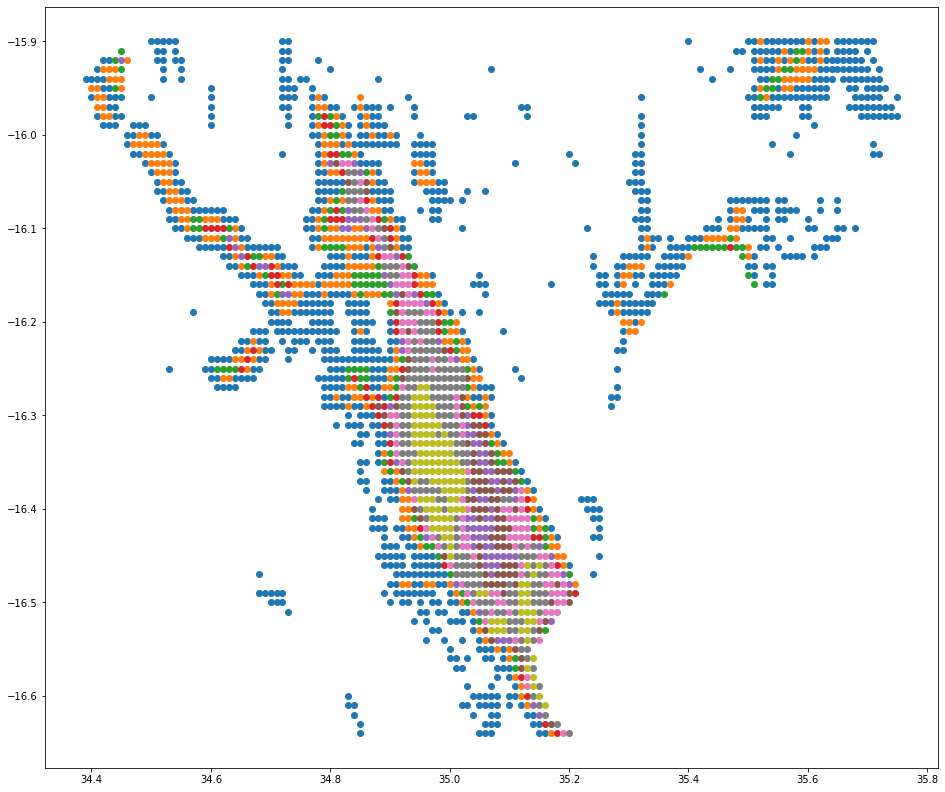

In [0]:
values = []
for i in range(10):
  values.append(df_low.query('target_2019>@i*0.1&target_2019<=(@i+1)*0.1'))
figure = plt.figure(figsize=(16,14))
for i in range(10):
  plt.scatter(np.array(values[i].X), np.array(values[i].Y))
  print(i, '--', values[i].target_2019.max())
plt.show()

In [0]:
"""Склеивание"""#Bonding
df_up = pd.DataFrame(data_old.query('Y>-15.9').iloc[:,[-4,0,1]])
df_up['target_2019'] = 0.
df_all = pd.concat([df_up,df_low])
df_all = df_all.merge(best, on=['Square_ID', 'X', 'Y'])
df_all.head()

,Square_ID,X,Y,target_2019,target
0,4e3c3898-14ce-11ea-bce5-f49634744a41,34.26,-15.89,0.0,0.0
1,4e3c3899-14ce-11ea-bce5-f49634744a41,34.26,-15.88,0.0,0.0
2,4e3c389a-14ce-11ea-bce5-f49634744a41,34.26,-15.87,0.0,0.0
3,4e3c389b-14ce-11ea-bce5-f49634744a41,34.26,-15.86,0.0,0.0
4,4e3c389c-14ce-11ea-bce5-f49634744a41,34.26,-15.85,0.0,0.0


In [0]:
df_all['target_2019'] = (df_all.target_2019+df_all.target)/2

0 -- 0.0998196261115832
1 -- 0.199323543347161
2 -- 0.2989765105564539
3 -- 0.3986027878156161
4 -- 0.4972680877322533
5 -- 0.5977081610618675
6 -- 0.6997538206246134
7 -- 0.799739675243927
8 -- 0.8985348453413144
9 -- 0.9095876945739283


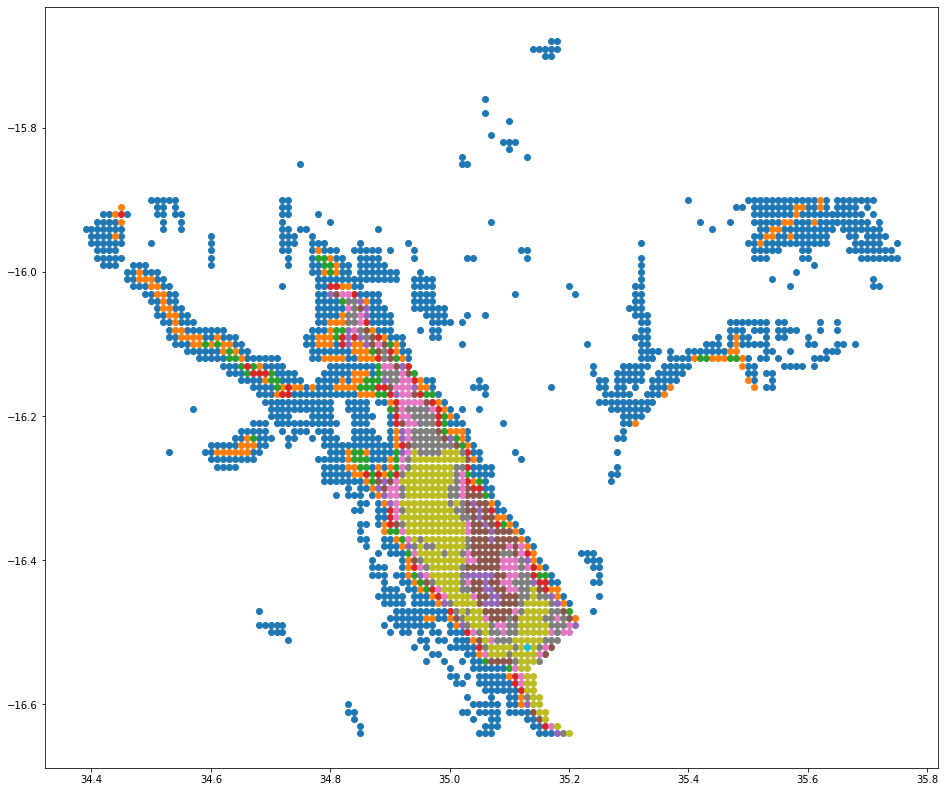

In [0]:
values = []
for i in range(10):
  values.append(df_all.query('target_2019>@i*0.1&target_2019<=(@i+1)*0.1'))
figure = plt.figure(figsize=(16,14))
for i in range(10):
  plt.scatter(np.array(values[i].X), np.array(values[i].Y))
  print(i, '--', values[i].target_2019.max())
plt.show()

In [0]:
df_up = pd.DataFrame(data_old.query('Y>-15.9').iloc[:,[-4,0,1]])
df_up['target_2019'] = 0.
df_all = pd.concat([df_up,df_all])

In [0]:
df_all.drop(['X', 'Y', 'target'], axis = 1).to_csv('submit_xgboost_mean.csv', index = False)